<a href="https://colab.research.google.com/github/se-yi/LSTM-Attention/blob/master/npi_covidex_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NPI-Context: Using intervention context to inform literature search with case study

1. We make it easier to conduct literature search for new interventions in specific environments by incorporating the context for each intervention in our search.

2. We demonstrate this method on a newly constructed dataset of Canadian NPIs (and Korean/Oxford if we have time)

3. Explain how this can scale. Lead to rapid design, execution, and assessment of interventions.

## Introduction

TODO: Make this relevant to readers in the future that barely know what COVID-19 is.

## Method


## Case Study: Canada

## Scale


Forked from demo. Using additional code and data from https://github.com/jajsmith/COVID19NonPharmaceuticalInterventions

This notebook provides a demo on how to get started in searching the [COVID-19 Open Research Dataset](https://pages.semanticscholar.org/coronavirus-research) (release of 2020/04/03) from AI2.

Contains the title + abstract index provided by the folks behind [covidex.io](https://covidex.io).

In [0]:
from IPython.core.display import display, HTML

In [0]:
%%capture
!pip install pyserini==0.8.1.0
!pip install transformers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import json
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

In [0]:
from pyserini.search import pysearch


In [34]:
!pip install geopandas

     |████████████████████████████████| 931kB 2.7MB/s 
     |████████████████████████████████| 14.7MB 288kB/s 
     |████████████████████████████████| 10.4MB 44.8MB/s 


In [0]:
from IPython.html.widgets import interactive
from ipywidgets import interact, interact_manual
from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider

from matplotlib import cm
import seaborn as sns
import matplotlib.patches as mpatches
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import AxesGrid
import geopandas as gpd

Let's grab the pre-built index:

In [0]:
%%capture
!wget https://www.dropbox.com/s/d6v9fensyi7q3gb/lucene-index-covid-2020-04-03.tar.gz
!tar xvfz lucene-index-covid-2020-04-03.tar.gz

Sanity check of index size (should be 1.5G):

In [0]:
!du -h lucene-index-covid-2020-04-03

1.5G	lucene-index-covid-2020-04-03


Let's load BioBERT (https://arxiv.org/abs/1901.08746) from HuggingFace Transformers

In [0]:
import torch
import numpy
from tqdm import tqdm
from transformers import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
#tokenizer = AutoTokenizer.from_pretrained('monologg/biobert_v1.1_pubmed', do_lower_case=False)
#model = AutoModel.from_pretrained('monologg/biobert_v1.1_pubmed')

Now let's grab the Canadian NPI dataset.

In [0]:
!wget https://raw.githubusercontent.com/jajsmith/COVID19NonPharmaceuticalInterventions/master/npi_full.csv

--2020-04-16 01:26:29--  https://raw.githubusercontent.com/jajsmith/COVID19NonPharmaceuticalInterventions/master/npi_full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5759143 (5.5M) [text/plain]
Saving to: ‘npi_full.csv.1’

npi_full.csv.1      100%[===================>]   5.49M  20.2MB/s    in 0.3s    

2020-04-16 01:26:29 (20.2 MB/s) - ‘npi_full.csv.1’ saved [5759143/5759143]



In [0]:
full_df = pd.read_csv('npi_full.csv')
full_df['start_date'] = pd.to_datetime(full_df['start_date'])
full_df['end_date'] = pd.to_datetime(full_df['end_date'])
full_df['oxford_fiscal_measure_cad'] = full_df['oxford_fiscal_measure_cad'].replace('[\$,]', '', regex=True).astype(float)

# Retrieving Research from Hand-crafted NPI Labels

In [0]:
full_df['intervention_category'].astype(str).unique()

array(['Testing Definition Change', 'Recommended self-isolation',
       'Public Announcement', 'Arena closure', 'Public Reassurance',
       'Travel Restriction (External)', 'Creation of command center',
       'Symptom screening', 'School closure', 'Employment Protections',
       'Public event size restriction (<=50)',
       'Social Distancing Announcement',
       'Declaration of emergency (or similar)',
       'Emergency healthcare funding', 'Non-essential workplace closure',
       'Emergency economic funding', 'Travel Restriction (Internal)',
       'Self-monitored quarantine', 'First case announcement',
       'Improve testing capacity', 'Public event size restriction (<=2)',
       'Concert hall closure', 'Border closure',
       'Healthcare facility restrictions', 'Self-reported screening',
       'Manufacturing repurposing', 'Emergency social services funding',
       'Public park closure', 'Social Service provider restrictions',
       'nan', 'Public park restrictions', 'G

In [0]:
searcher = pysearch.SimpleSearcher('lucene-index-covid-2020-04-03/')
label_hits = []
label_docids = []
for intervention in full_df['intervention_category'].astype(str).unique():
  hits = searcher.search(intervention)
  label_hits.append(hits)
  print("Search term: ", intervention)
  print("  hits:", len(hits))
  scores = [h.score for h in hits]
  print("  mean score:", np.mean(scores))
  for i in range(0, 5):
    print(f'{i+1:2} {hits[i].docid} {hits[i].score:.5f} {hits[i].lucene_document.get("title")} {hits[i].lucene_document.get("doi")}')
    label_docids.append(hits[i].docid)

Search term:  Testing Definition Change
  hits: 10
  mean score: 5.249479961395264
 1 vibyd47l 5.83300 Impact of changing case definitions for COVID-19 on the epidemic curve and transmission parameters in mainland China 10.1101/2020.03.23.20041319
 2 t3jf5rus 5.46970 The relationship between porcine circovirus 2 antigen score and antibody titre and histology of lymph nodes in 375 euthanased sick and healthy pigs from 113 British pig farms with and without postweaning multisystemic wasting syndrome 10.1016/j.prevetmed.2008.11.001
 3 6cj539uw 5.35390 Is influenza-like illness a useful concept and an appropriate test of influenza vaccine effectiveness? 10.1016/j.vaccine.2014.02.059
 4 fogmo7wt 5.34440 Lessons for managing high-consequence infections from first COVID-19 cases in the UK 10.1016/s0140-6736(20)30463-3
 5 w5fxen70 5.20780 Reliability of case definitions for public health surveillance assessed by Round-Robin test methodology 10.1186/1471-2458-6-129
Search term:  Recommended sel

# Keyword Selection from LDA Topics on NPI Announcement Text

In [0]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text 

In [0]:
def topic_selection(tf, tmax, tstep, debug=False):
    topic_sizes = np.arange(1, tmax, tstep)
    topic_ll = []
    topic_perplexity = []
    models = []
    for k in topic_sizes:
        n_topics = k
        lda = LatentDirichletAllocation(n_components=n_topics, 
            max_iter=10, 
            learning_method='online',
            learning_offset=50.,
            random_state=3).fit(tf)

        # use perplexity for now.. try gensim coherence later
        # see https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_coherence_model_selection.ipynb
        topic_ll.append( lda.score(tf) )
        p = lda.perplexity(tf)
        topic_perplexity.append( p )
        models.append(lda)
        
        if (debug):
            print('Topics: ', k, ' perplexity ', p)
    
    idx = np.where(topic_perplexity == np.amin(topic_perplexity))[0][0]
    selected_lda = models[idx]
    ntopics = topic_sizes[idx]
    return topic_sizes, topic_perplexity, selected_lda, ntopics

In [0]:
def show_topk_words(lda, k, tf_feature_names):
    n_top_words = k
    for topic_i, topic in enumerate(lda.components_):
        print( "Topic ", topic_i )
        print( "Words: ", [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] )
        

## Constructing text corpus

We choose to leave out geography-related words by marking them as stop words. This seems to prevent the model from picking up on the strong geographical topics in our selection of data and helps it discover other useful clusters. This is helpful when searching for research that may be interventionally-aligned but not geographically-aligned.

In [0]:
r = [x.split() for x in full_df['region'].dropna().unique().tolist()]
r = np.hstack([np.array(x) for x in r])
sr = [x.split() for x in full_df['subregion'].dropna().unique().tolist()]
sr = np.hstack([np.array(x) for x in sr])
geo_stop_words = np.append(r, sr)
geo_stop_words = [x.lower() for x in geo_stop_words]
geo_stop_words = [x.replace('(','').replace(')','') for x in geo_stop_words]
stop_words = text.ENGLISH_STOP_WORDS.union(geo_stop_words)

We also drop all the Quebec interventions which generally have their full text in french.

In [0]:
engl_df = full_df[full_df['region'] != 'Quebec']
full_text = engl_df['source_full_text'].drop_duplicates().astype(str)
data = full_text.values
data = [re.sub('\s+', ' ', text) for text in data] # remove new lines
data = [re.sub("\'", "", text) for text in data] # remove quotes
print("Total number of documents: ", len(data))

Total number of documents:  838


In [0]:
n_words = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words, stop_words=stop_words)
tf = tf_vectorizer.fit_transform( data )
tf_feature_names = tf_vectorizer.get_feature_names()

topic_sizes, topic_perplexity, lda, ntopics = topic_selection(tf, 40, 2)
print("Selected ", ntopics, " topics")

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abitibi', 'ahuntsic', 'baie', 'bas', 'bizard', 'cartierville', 'cdn', 'cote', 'cries', 'dela', 'du', 'extension', 'gaspesie', 'geneviève', 'hochelaga', 'iles', 'james', 'john', 'kitchener', 'la', 'lac', 'laurent', 'madeleine', 'maisonneuve', 'marie', 'mercier', 'michel', 'mont', 'montréal', 'ndg', 'nord', 'ouest', 'parc', 'patrie', 'petite', 'pierrefonds', 'plateau', 'rosemont', 'roxboro', 'royal', 'saguenay', 'saint', 'sainte', 'saintjean', 'st', 'sud', 'temiscamingue', 'terres', 'ville', 'villeray', 'île'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Selected  17  topics


Text(0, 0.5, 'perplexity')

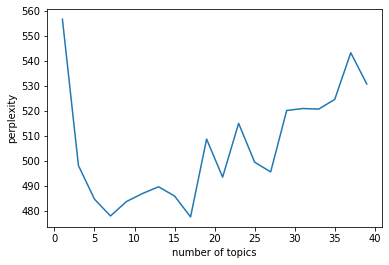

In [0]:
plt.plot(topic_sizes, topic_perplexity)
plt.xlabel('number of topics')
plt.ylabel('perplexity')

In [0]:
show_topk_words(lda, 20, tf_feature_names)

Topic  0
Words:  ['parking', 'enforcement', 'street', 'residential', 'permit', 'residents', 'suspending', 'end', 'time', 'healthcare', 'permits', 'april', 'temporarily', 'workers', 'home', 'staff', 'fees', 'staying', 'help', 'hour']
Topic  1
Words:  ['health', 'public', 'officer', 'order', 'chief', 'medical', 'emergency', 'act', 'measures', 'covid', '19', '2020', 'dr', 'protect', 'spread', 'march', 'orders', 'nwt', 'section', 'minister']
Topic  2
Words:  ['services', 'march', '2020', 'ca', 'public', '19', 'service', 'closed', 'april', 'covid', 'information', '30', 'facilities', 'continue', 'available', 'time', 'cancelled', 'monday', 'customers', 'community']
Topic  3
Words:  ['health', '19', 'covid', 'social', 'continue', 'services', 'information', 'need', 'care', 'essential', 'service', 'government', 'support', 'people', 'residents', 'march', 'ca', 'community', 'symptoms', 'nwt']
Topic  4
Words:  ['cbc', 'news', 'visitors', 'visitor', 'says', 'policy', 'day', '11', 'precautions', 'can

## Conduct Search

In [0]:
searcher = pysearch.SimpleSearcher('lucene-index-covid-2020-04-03/')
lda_hits = []
lda_docids = []
n_top_words = 10
for topic_i, topic in enumerate(lda.components_):
  print( "Topic ", topic_i )
  words = [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
  search_term = " ".join(words)
  hits = searcher.search(search_term)
  lda_hits.append(hits)
  print("Search terms: ", words)
  print("  hits:", len(hits))
  scores = [h.score for h in hits]
  print("  mean score:", np.mean(scores))
  for i in range(0, 5):
    print(f'{i+1:2} {hits[i].docid} {hits[i].score:.5f} {hits[i].lucene_document.get("title")} {hits[i].lucene_document.get("doi")}')
    lda_docids.append(hits[i].docid)


Topic  0
Search terms:  ['parking', 'enforcement', 'street', 'residential', 'permit', 'residents', 'suspending', 'end', 'time', 'healthcare']
  hits: 10
  mean score: 8.632149982452393
 1 ihxy08c7 9.99210 Street-level diplomacy and local enforcement for meat safety in northern Tanzania: knowledge, pragmatism and trust 10.1186/s12889-019-7067-8
 2 lo4hqokv 9.87420 Source identification of total petroleum hydrocarbons and polycyclic aromatic hydrocarbons in PM10 and street dust of a hot spot for petrochemical production: Asaluyeh County, Iran 10.1016/j.scs.2018.11.015
 3 i4q0ljb0 8.99580 Seasonal evaluation of bioaerosols from indoor air of residential apartments within the metropolitan area in South Korea 10.1007/s10661-013-3521-8
 4 2q8r5w2o 8.65260 Role of healthcare apparel and other healthcare textiles in the transmission of pathogens: a review of the literature 10.1016/j.jhin.2015.02.017
 5 9y9gjyby 8.49480 The experience of SARS-related stigma at Amoy Gardens 10.1016/j.socscimed.2

# Comparison of Search Results


In [0]:
len(label_hits)

62

In [0]:
len(lda_hits)

17

In [0]:
len(np.unique(label_docids))

246

In [0]:
len(np.unique(lda_docids))

83

In [0]:
common_results = np.intersect1d(np.unique(label_docids), np.unique(lda_docids))
print("results in common: ", len(common_results))
common_results

results in common:  9


array(['4kzv06e6', '4tx7u2i9', '8c2n1c7u', 'jof8lij8', 'nx2wrguu',
       'qac68abi', 'us7d19p5', 'xhem8l39', 'yy7abob9'], dtype='<U8')

# Further Demo Instructions Below

From the hits array, use `.lucene_document` to access the underlying indexed Lucene `Document`, and from there, call `.get(field)` to fetch specific fields, like "title", "doc", etc.
The complete list of available fields is [here](https://github.com/castorini/anserini/blob/master/src/main/java/io/anserini/index/generator/CovidGenerator.java#L46).

For hit #2, "A Chinese Case of COVID-19 Did Not Show Infectivity During the Incubation Period", we don't have the full text, but we can access available information via `.raw`.

In [0]:
hit2_json = json.loads(hits[1].raw)
print(json.dumps(hit2_json, indent=4))

{
    "abstract": "Controversy remains over whether the novel coronavirus 2019 (COVID-19) virus may have infectivity during the incubation period before the onset of symptoms. The author had the opportunity to examine the infectivity of COVID-19 during the incubation period by conducting an epidemiological survey on a confirmed patient who had visited Jeju Island during the incubation period. The epidemiological findings support the claim that the COVID-19 virus does not have infectivity during the incubation period.",
    "authors": "Bae, Jong-Myon",
    "cord_uid": "slapc5xt",
    "doi": "10.3961/jpmph.20.048",
    "full_text_file": "",
    "has_pdf_parse": "False",
    "has_pmc_xml_parse": "False",
    "journal": "Journal of Preventive Medicine and Public Health",
    "license": "unk",
    "Microsoft Academic Paper ID": "2029228287",
    "pmcid": "",
    "publish_time": "2020-03-02",
    "pubmed_id": "32114755",
    "sha": "",
    "source_x": "WHO",
    "title": "A Chinese Case of C

For hit #4, "The Incubation Period of Coronavirus Disease 2019 (COVID-19) From Publicly Reported Confirmed Cases", we have the full text, which we can also fetch via `.raw`:


In [0]:
hit4_json = json.loads(hits[3].raw)
print(json.dumps(hit4_json, indent=4))

{
    "paper_id": "ce8609a60724d457d5b5916d57a31dea0ffb831b",
    "metadata": {
        "title": "The Incubation Period of Coronavirus Disease 2019 (COVID-19) From Publicly Reported Confirmed Cases: Estimation and Application",
        "authors": [
            {
                "first": "Stephen",
                "middle": [
                    "A"
                ],
                "last": "Lauer",
                "suffix": "",
                "affiliation": {},
                "email": ""
            },
            {
                "first": "Kyra",
                "middle": [
                    "H"
                ],
                "last": "Grantz",
                "suffix": "",
                "affiliation": {},
                "email": ""
            },
            {
                "first": "Qifang",
                "middle": [],
                "last": "Bi",
                "suffix": "",
                "affiliation": {},
                "email": ""
            },
            

# Visualizations

In [0]:
%%html
<div class='tableauPlaceholder' id='viz1586995220180' style='position: relative'  ><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;On&#47;OntarioInterventions&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='OntarioInterventions&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;On&#47;OntarioInterventions&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1586995220180');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>


## Interactive visualizations using Canadian NPI Dataset.

In [26]:
!wget https://flatteningthecurve.herokuapp.com/data/covid

--2020-04-16 04:02:22--  https://flatteningthecurve.herokuapp.com/data/covid
Resolving flatteningthecurve.herokuapp.com (flatteningthecurve.herokuapp.com)... 35.173.44.176, 52.7.163.77, 3.208.142.121, ...
Connecting to flatteningthecurve.herokuapp.com (flatteningthecurve.herokuapp.com)|35.173.44.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2484255 (2.4M) [text/csv]
Saving to: ‘covid’

covid               100%[===================>]   2.37M  --.-KB/s    in 0.1s    

2020-04-16 04:02:23 (24.5 MB/s) - ‘covid’ saved [2484255/2484255]



In [0]:
full_cases = pd.read_csv('covid')

In [0]:
intervention_categories = ['S1 School Closing',
                           'S2 Workplace closing',
                           'S3 Cancel public events',
                           'S4 Close public transport',
                           'S5 Public info campaigns',
                           'S6 Restrictions on internal movements',
                           'S7 International travel controls',
                           'S8 Fiscal measures',
                           'S9 Monetary measures (interest rate)',
                           'S10 Emergency investment in health care',
                           'S11 Investment in vaccines',
                           'S12 Testing policy',
                           'S13 Contact tracing']

In [0]:
def parse_rate(string):
    if type(string) == float:
        return string
    cad = string[:-1]
    return float(cad)

def impute_intervention(prov):
    for interv_cat in intervention_categories:
        prov[interv_cat] = 0
    closure_geo = ['S1', 'S2', 'S3', 'S4', 'S6']
    public_geo = ['S5']
    travel = ['S7']
    rate = ['S9']
    fiscal = ['S8', 'S10', 'S11']
    test = ['S12']
    trace = ['S13']
    for idx, row in prov.iterrows():
        interv = row['oxford_government_response_category']
        if interv in intervention_categories:
            interv_prefix = str(interv).split(' ')[0]
            subset = prov.iloc[:idx+1]
            subset = subset[subset['oxford_government_response_category'] == interv]
            if interv_prefix in closure_geo:
                prov.at[idx, interv] = (np.nanmax(subset['oxford_closure_code']) + np.nanmax(subset['oxford_geographic_target_code'])) * 100 / 3
            elif interv_prefix in public_geo:
                prov.at[idx, interv] = (np.nanmax(subset['oxford_geographic_target_code']) + np.nanmax(subset['oxford_public_info_code'])) * 100 / 2
            elif interv_prefix in travel:
                prov.at[idx, interv] = (subset['oxford_travel_code'].max()) * 100 / 3
            elif interv_prefix in rate:
                prov.at[idx, interv] = subset['oxford_monetary_measure'].apply(parse_rate).sum()
            elif interv_prefix in fiscal:
                prov.at[idx, interv] = pd.to_numeric(subset['oxford_fiscal_measure_cad']).sum()
            elif interv in test:
                prov.at[idx, interv] = subset['oxford_testing_code'].max() * 100 / 2
            elif interv in trace:
                prov.at[idx, interv] = subset['oxford_tracing_code'].max() * 100 / 2
            if idx > 0:
                for i in intervention_categories:
                    if i != interv:
                        prov.at[idx, i] = prov.at[idx-1, i]
        else:
            if idx > 0:
                for i in intervention_categories:
                    prov.at[idx, i] = prov.at[idx-1, i]
    return prov

In [0]:
def construct_positive(prov):
    prov['Cumulative Cases'] = 0
    for idx, row in prov.iterrows():
        if idx == 0:
            prov.at[0, 'Cumulative Cases'] = prov.iloc[0]['Daily Cases']
        else:
            prov.at[idx, 'Cumulative Cases'] = prov.iloc[idx-1]['Cumulative Cases'] + prov.iloc[idx]['Daily Cases']
    
    return prov

In [0]:
def generate_cases_province(full_npi, pn, pn_short):
    prov = full_npi[(full_npi['region'] == pn)]
    
    # mb_list = ['Region', pn, pn+'.1', pn+'.2', pn+'.3', pn+'.4', pn+'.5']
    # mb = mobility[mb_list]
    # mb = mb.rename(columns={mb_list[0]: 'start_date',
    #                         mb_list[1]: mobility_list[0],
    #                         mb_list[2]: mobility_list[1],
    #                         mb_list[3]: mobility_list[2],
    #                         mb_list[4]: mobility_list[3],
    #                         mb_list[5]: mobility_list[4],
    #                         mb_list[6]: mobility_list[5]
    #                         })
    # mb = mb.iloc[1:]
    # mb['start_date'] = pd.to_datetime(mb['start_date'], format='%d-%m-%Y')
    # for mb_type in mobility_list:
    #     mb[mb_type] = pd.to_numeric(mb[mb_type])
    #     mb[mb_type] = mb[mb_type].apply(lambda x: scale_mob(x, mb[mb_type].min(), mb[mb_type].max()))
       
    prov = prov[['start_date', 'region', 'end_date', 'oxford_government_response_category', 'oxford_closure_code',
       'oxford_public_info_code', 'oxford_travel_code',
       'oxford_geographic_target_code', 'oxford_fiscal_measure_cad',
       'oxford_monetary_measure', 'oxford_testing_code', 'oxford_tracing_code']]
    
    prov['start_date'] =  pd.to_datetime(prov['start_date'], infer_datetime_format='%m/%d/%Y')
    
    cs = full_cases[full_cases['province'] == pn_short]
    cs['start_date'] = pd.to_datetime(cs['date'], format='%Y-%m-%d')
    cs = cs.groupby('start_date')['id'].agg('count').reset_index().rename(columns={'id': 'Daily Cases'})
    cs = construct_positive(cs)
    
    # prov = pd.merge(prov, mb[['start_date'] + mobility_list], on='start_date', how='outer')
    prov = pd.merge(prov, cs, on='start_date', how='outer')
    prov = prov.sort_values(by='start_date',ascending=True).reset_index(drop=True)
    
    prov = impute_intervention(prov)
    prov = prov.drop_duplicates(subset ="start_date", 
                     keep = 'last').reset_index(drop=True) 
    
    
    return prov

In [0]:
full_viz = full_df.copy()
full_viz['oxford_geographic_target_code'].fillna(0, inplace=True)
full_viz['oxford_closure_code'].fillna(0, inplace=True)
full_viz['oxford_public_info_code'].fillna(0, inplace=True)

In [71]:
on = generate_cases_province(full_viz, 'Ontario', 'Ontario')
qb = generate_cases_province(full_viz, 'Quebec', 'Quebec')
bc = generate_cases_province(full_viz, 'British Columbia', 'BC')
sk = generate_cases_province(full_viz, 'Saskatchewan', 'Saskatchewan')
nb = generate_cases_province(full_viz, 'New Brunswick', 'New Brunswick')
ns = generate_cases_province(full_viz, 'Nova Scotia', 'Nova Scotia')
mb = generate_cases_province(full_viz, 'Manitoba', 'Manitoba')
ab = generate_cases_province(full_viz, 'Alberta', 'Alberta')
pei = generate_cases_province(full_viz, 'Prince Edward Island', 'PEI')
nwt = generate_cases_province(full_viz, 'Northwest Territories', 'NWT')
nl = generate_cases_province(full_viz, 'Newfoundland and Labrador', 'NL')
yt = generate_cases_province(full_viz, 'Yukon', 'Yukon')
nv = generate_cases_province(full_viz, 'Nunavut', 'Nunavut')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
prov_dict = {'Ontario': on,
             'Quebec': qb,
             'British Columbia': bc,
             'Saskatchewan': sk,
             'New Brunswick': nb,
             'Nova Scotia': ns,
             'Manitoba' : mb,
             'Alberta' : ab,
             'Prince Edward Island': pei,
             'Northwest Territories' : nwt,
             'Newfoundland and Labrador' : nl,
             'Yukon': yt,
             'Nunavut': nv}
prov_list = ['Ontario', 'Quebec', 'British Columbia', 'Saskatchewan', 
             'New Brunswick', 'Nova Scotia', 'Manitoba', 'Alberta',
             'Prince Edward Island', 'Northwest Territories', 'Newfoundland and Labrador', 'Yukon', 'Nunavut']

In [0]:
w_prov1 = widgets.Select(description="Province 1", options=prov_list)
w_prov2 = widgets.Select(description="Province 2", options=prov_list)
w_intervention_multi = widgets.SelectMultiple(description="Different intervention types",
                                             options=intervention_categories)
w_stats = widgets.Select(description="Different COVID-19 indicators",
                         options=['Daily Cases', 'Cumulative Cases'])
w_stringency = widgets.Select(description="Stringency Index", options=[1, 33, 50, 66, 100])

In [0]:
def compare_provinces_cases(prov1_str, prov2_str, interv_type, stat, stringency_idx):
    prov1 = prov_dict[prov1_str]
    prov2 = prov_dict[prov2_str]
    
    if stat == "Daily Cases":
        height = 50
    else:
        height = 500
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(15, 10))
    colors = sns.color_palette("Set2", n_colors=8)
    legend_labels = [mpatches.Patch(color=colors[0], label=stat)]
    
    begin_date = np.datetime64('2020-02-15')
    
    if prov1['start_date'].values[-1] > prov2['start_date'].values[-1]:
        end_date = prov2['start_date'].values[-1]
    else:
        end_date = prov1['start_date'].values[-1]
        
    ax1.set_xlim(left=begin_date, right=end_date)
    
    ax1.bar(prov1['start_date'], prov1[stat], color=colors[0])
    ax1.set(ylabel=stat, title=prov1_str)
    
    ax2.bar(prov2['start_date'], prov2[stat], color=colors[0])
    ax2.set(xlabel = 'Date', ylabel=stat, title=prov2_str)
    
    for idx in range(len(interv_type)):
        if len(prov1[prov1[interv_type[idx]] >= stringency_idx]['start_date']) :
            first_date_1 = prov1[prov1[interv_type[idx]] >= stringency_idx]['start_date'].values[0]
            second_date_1 = first_date_1 + np.timedelta64(14,'D')
            
            ax1.axvline(x=first_date_1, linestyle='-', color=colors[1+idx])
            ax1.text(first_date_1+ np.timedelta64(8, 'h'), height, interv_type[idx],rotation=90)
            ax1.axvspan(second_date_1, end_date, facecolor= colors[1+idx], alpha=0.4)
            ax1.text(second_date_1+ np.timedelta64(8, 'h'), height,
                    interv_type[idx].split(' ')[0] + ' - after 14 days',rotation=90)
        
        if len(prov2[prov2[interv_type[idx]] >= stringency_idx]['start_date']) :
            first_date_2 = prov2[prov2[interv_type[idx]] >= stringency_idx]['start_date'].values[0]
            second_date_2 = first_date_2 + np.timedelta64(14,'D')
            
            ax2.axvline(x=first_date_2, linestyle='-', color=colors[1+idx])
            ax2.text(first_date_2+ np.timedelta64(8, 'h'),height, interv_type[idx],rotation=90)
            
            ax2.axvspan(second_date_2, end_date, facecolor= colors[1+idx], alpha=0.4)
            ax2.text(second_date_2+ np.timedelta64(8, 'h'), height,
                    interv_type[idx].split(' ')[0] + ' - after 14 days',rotation=90)
        
    
        legend_labels.append(mpatches.Patch(color=colors[1+idx], label=interv_type[idx]))  

    ax1.legend(handles=legend_labels, loc=2)
    ax2.legend(handles=legend_labels, loc=2)
    
    plt.show()

In [0]:
def view_case_provinces(p1, p2, i, nb, s):
    display(compare_provinces_cases(p1, p2, i, nb, s))

In [76]:
interactive(view_case_provinces, p1=w_prov1, p2=w_prov2, i=w_intervention_multi,
            nb=w_stats, s=w_stringency)

interactive(children=(Select(description='Province 1', options=('Ontario', 'Quebec', 'British Columbia', 'Sask…

## Map showing the evolution of Stringency Indexes over time

In [53]:
!wget https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/files-fichiers/2016/lpr_000b16a_e.zip

--2020-04-16 04:17:28--  https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/files-fichiers/2016/lpr_000b16a_e.zip
Resolving www12.statcan.gc.ca (www12.statcan.gc.ca)... 205.193.226.138
Connecting to www12.statcan.gc.ca (www12.statcan.gc.ca)|205.193.226.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28630859 (27M) [application/x-zip-compressed]
Saving to: ‘lpr_000b16a_e.zip.1’

lpr_000b16a_e.zip.1 100%[===================>]  27.30M  1.74MB/s    in 16s     

2020-04-16 04:17:45 (1.68 MB/s) - ‘lpr_000b16a_e.zip.1’ saved [28630859/28630859]

gzip: stdin has more than one entry--rest ignored
tar: This does not look like a tar archive
tar: Skipping to next header
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [54]:
!unzip lpr_000b16a_e.zip

Archive:  lpr_000b16a_e.zip
  inflating: lpr_000b16a_e.dbf       
  inflating: lpr_000b16a_e.prj       
  inflating: lpr_000b16a_e.shp       
  inflating: lpr_000b16a_e.shx       
  inflating: province_territory.html  
  inflating: 92-160-g2016002-eng.pdf  


In [0]:
date1 = np.datetime64('2020-03-11')
date2 = np.datetime64('2020-03-16')
date3 = np.datetime64('2020-03-31')
interv_string = ['S1 School Closing',
                           'S2 Workplace closing',
                           'S3 Cancel public events',
                           'S4 Close public transport',
                           'S5 Public info campaigns',
                           'S6 Restrictions on internal movements',
                           'S7 International travel controls']

In [0]:
canada = gpd.GeoDataFrame.from_file('lpr_000b16a_e.shp')

In [0]:
def string_idx(df, date):
    sub = df[df['start_date'] <= date]
    if len(sub):
        sub['stringency'] = sub.apply(lambda r: r[interv_string].fillna(0).values.mean(), axis=1)
        return sub['stringency'].max()
    else:
        return 0

In [77]:
stringency_idx1 = pd.DataFrame(columns={'PRENAME', 'Stringency1'})
for k, v in prov_dict.items():
    stringency_idx1 = stringency_idx1.append({'PRENAME': k,
                      'Stringency1': string_idx(v, date1)}, ignore_index=True)
    
stringency_idx2 = pd.DataFrame(columns={'PRENAME', 'Stringency2'})
for k, v in prov_dict.items():
    stringency_idx2 = stringency_idx2.append({'PRENAME': k,
                      'Stringency2': string_idx(v, date2)}, ignore_index=True)
    
stringency_idx3 = pd.DataFrame(columns={'PRENAME', 'Stringency3'})
for k, v in prov_dict.items():
    stringency_idx3 = stringency_idx3.append({'PRENAME': k,
                      'Stringency3': string_idx(v, date3)}, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
canada_stringency = pd.merge(canada, stringency_idx1, on='PRENAME')
canada_stringency = pd.merge(canada_stringency, stringency_idx2, on='PRENAME')
canada_stringency = pd.merge(canada_stringency, stringency_idx3, on='PRENAME')

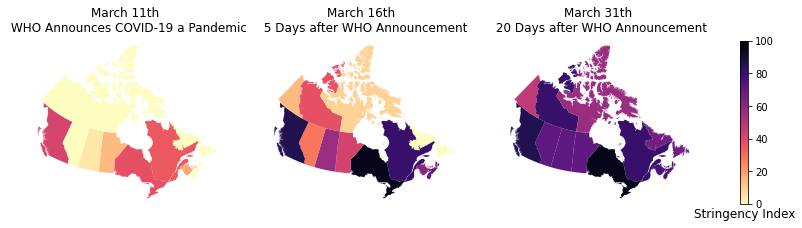

In [79]:
fig, axs = plt.subplots(1, 3, figsize=(15, 15))


axs[0] = canada_stringency.plot('Stringency1', cmap='magma_r', ax=axs[0], vmin=0, vmax=100)

axs[0].set_title('March 11th \n WHO Announces COVID-19 a Pandemic')
axs[0].axis('off')
axs[0].set_xlabel('WHO Announces COVID-19 a Pandemic')


axs[1] = canada_stringency.plot(column='Stringency2', cmap='magma_r', ax=axs[1], vmin=0, vmax=100)
axs[1].set_title('March 16th \n 5 Days after WHO Announcement')
axs[1].axis('off')

axs[2] = canada_stringency.plot(column='Stringency3', cmap='magma_r', ax=axs[2], vmin=0, vmax=100)
axs[2].set_title('March 31th \n 20 Days after WHO Announcement')
axs[2].axis('off')

sm = plt.cm.ScalarMappable(cmap='magma_r', norm=plt.Normalize(vmin=0, vmax=100))

cbar = fig.colorbar(sm, ax=axs, shrink=0.2, location='right')
cbar.ax.get_yaxis().set_ticks([0, 20, 40, 60, 80, 100])
cbar.ax.set_xlabel('Stringency Index', fontsize=12)

plt.show()